In [43]:
from Phi import *
import torch
import math
from torch import nn, optim
import torch.nn.functional as F
from torchdiffeq import odeint, odeint_adjoint
from utils.ToyModels import *
import matplotlib.pyplot as plt

device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')

In [44]:
class OdeFunc(nn.Module):
    """
        Generate the object of ODE function we want to learn.
    :param d: int: dimension of the input
    :param m: int: dimension of the hidden layer
    :param nTh: int: number of the thetas
    """
    def __init__(self, d: int, m:int, nTh: int):
        super(OdeFunc, self).__init__()
        self.d = d
        self.m = m
        self.nTh = nTh
        self.net = Phi(self.nTh, self.m, self.d).to(device)

    """
        Forward pass of the ODE function
    :param t: torch.Tensor: time
    :param x: torch.Tensor: input in dimension d + 3, the augment vector [z, l, L, R] (where z is the d dimension random variable.)
    :return: torch.Tensor: output of the ODE function
    """
    def forward(self, t, x):
        x = x[:, :self.d]
        z = torch.cat((x, t*torch.ones(x.shape[0],1).to(device)), 1)
        gradPhi, trH = self.net.trHess(z)
        dx = - gradPhi[:,:self.d]
        dl = - trH.unsqueeze(1)
        dv = 0.5 * torch.sum(torch.pow(dx, 2), 1, keepdim=True)
        dr = torch.abs(-gradPhi[:,-1].unsqueeze(1) +  dv)
        return torch.cat((dx, dl, dv, dr), 1)



In [45]:
d = 2
m = 64
OTFlow = OdeFunc(d,m, 2).to(device)     # Initialize the ODE function
t0 = 0
t1 = 1
p_z1 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[1, 0.0], [0.0, 1]]).to(device)
)

vis_z1 = p_z1.sample((9000,))
vis_z1 = F.pad(vis_z1, [0,3,0,0], value=0)

# gaussians

In [46]:
def get_batch(n_sample):
    x, _ = generate_gaussians_data(n_samples=n_sample)
    return x

In [47]:
checkpoint_gaussians = torch.load('./OT-Flow/gaussians/gaussians12000.pth', map_location=device)
OTFlow.load_state_dict(checkpoint_gaussians['model_state_dict'])
OTFlow.eval()
X = get_batch(9000)

with torch.no_grad():
    vis_z0 = odeint(OTFlow, vis_z1, torch.linspace(t1,t0,1000).to(device), method='dopri5')
    


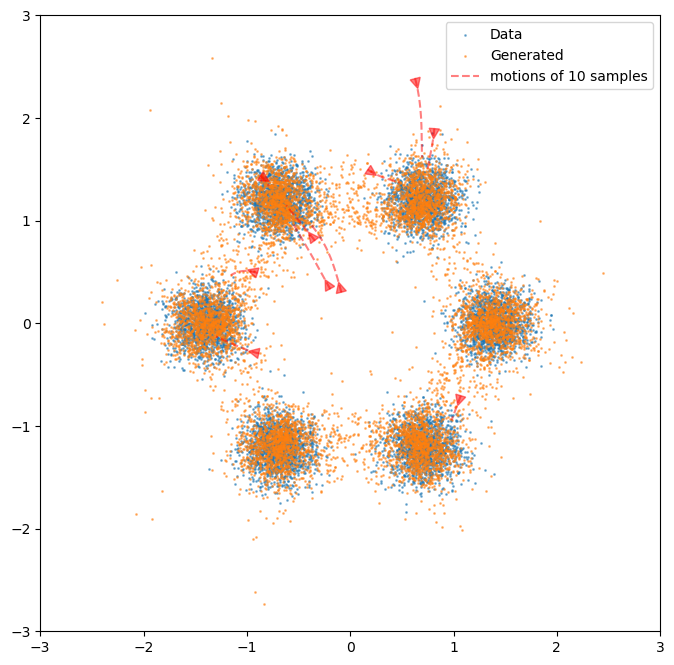

In [48]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
s1 = ax.scatter(*X.detach().cpu().T, s=1, alpha=0.5, label="Data")
s2 = ax.scatter(*vis_z0[-1][:,:d].detach().cpu().T, s=1, alpha=0.5, label="Generated")
for i in range(10):
    l = ax.plot(*vis_z0[:,i,:][:,:d].T, c = "r", alpha=0.5,linestyle="--", label = "motions of 10 samples" if i == 0 else "")
    ax.arrow(*vis_z0[0,i,:][:d].cpu(), *(vis_z0[3,i,:][:d]-vis_z0[0,i,:][:d]).cpu(), head_width=0.1, head_length=0.1, fc='r', ec='r', alpha=0.5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
# ax.legend([s1, s2], ["Data", "Generated"])
ax.legend()
plt.show()

# Moons

In [49]:
def get_batch(n_sample):
  x, _ = generate_moon_data(n_samples=n_sample, noise=2e-1)
  return x

In [50]:

checkpoint_moons = torch.load('./OT-Flow/moons/moons97000.pth', map_location=device)
OTFlow.load_state_dict(checkpoint_moons['model_state_dict'])
OTFlow.eval()
X = get_batch(9000)

with torch.no_grad():
    vis_z0 = odeint(OTFlow, vis_z1, torch.linspace(t1,t0,1000).to(device), method='dopri5')
    


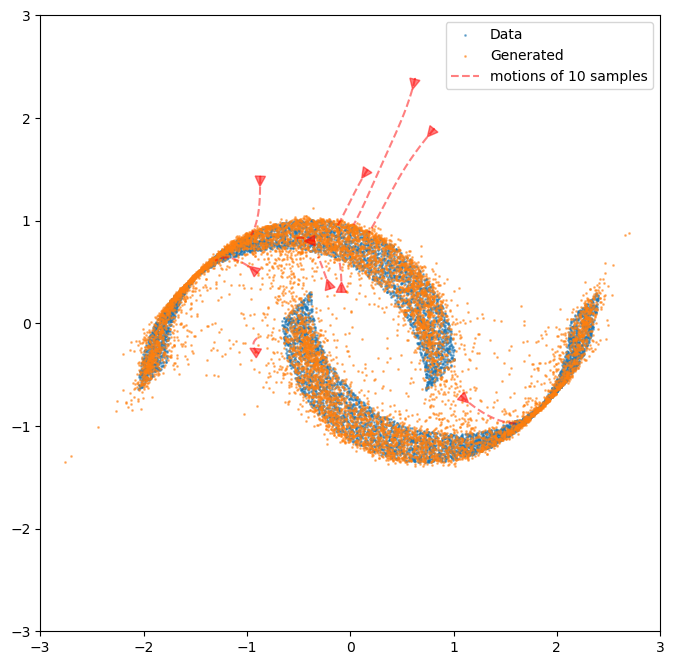

In [51]:

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
s1 = ax.scatter(*X.detach().cpu().T, s=1, alpha=0.5, label="Data")
s2 = ax.scatter(*vis_z0[-1][:,:d].detach().cpu().T, s=1, alpha=0.5, label="Generated")
for i in range(10):
    l = ax.plot(*vis_z0[:,i,:][:,:d].T, c = "r", alpha=0.5,linestyle="--", label = "motions of 10 samples" if i == 0 else "")
    ax.arrow(*vis_z0[0,i,:][:d].cpu(), *(vis_z0[3,i,:][:d]-vis_z0[0,i,:][:d]).cpu(), head_width=0.1, head_length=0.1, fc='r', ec='r', alpha=0.5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
# ax.legend([s1, s2], ["Data", "Generated"])
ax.legend()
plt.show()

# Spheres

In [52]:
def get_batch(n_sample):
  x, _ = generate_spheres_data(n_sample, noise=8e-2)
  return x

In [53]:

checkpoint_spheres = torch.load('./OT-Flow/spheres/spheres15400.pth', map_location=device)
OTFlow.load_state_dict(checkpoint_spheres['model_state_dict'])
OTFlow.eval()
X = get_batch(9000)

with torch.no_grad():
    vis_z0 = odeint(OTFlow, vis_z1, torch.linspace(t1,t0,1000).to(device), method='dopri5')
    


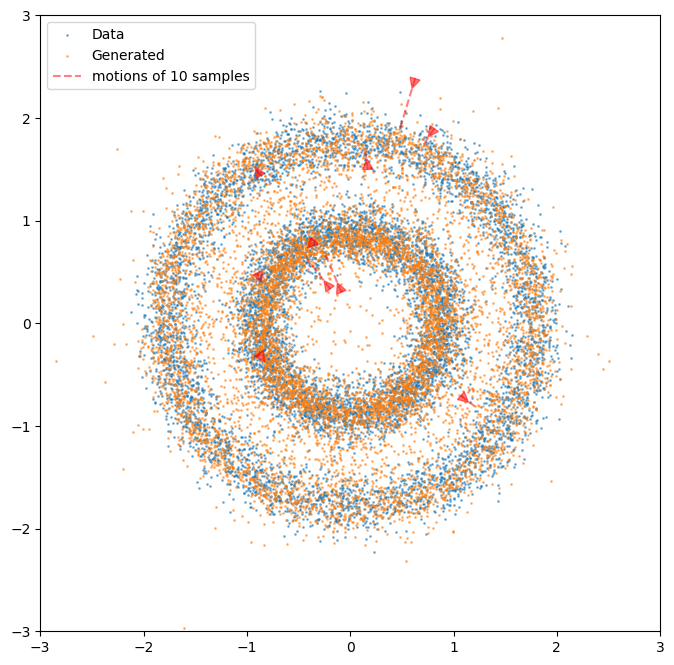

In [54]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
s1 = ax.scatter(*X.detach().cpu().T, s=1, alpha=0.5, label="Data")
s2 = ax.scatter(*vis_z0[-1][:,:d].detach().cpu().T, s=1, alpha=0.5, label="Generated")
for i in range(10):
    l = ax.plot(*vis_z0[:,i,:][:,:d].T, c = "r", alpha=0.5,linestyle="--", label = "motions of 10 samples" if i == 0 else "")
    ax.arrow(*vis_z0[0,i,:][:d].cpu(), *(vis_z0[3,i,:][:d]-vis_z0[0,i,:][:d]).cpu(), head_width=0.1, head_length=0.1, fc='r', ec='r', alpha=0.5)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
# ax.legend([s1, s2], ["Data", "Generated"])
ax.legend()
plt.show()